# Vodafone Challenge
## Scrap notebook
- **Separate each test** you make with a markdown cell like this one (press M when the cursor is on a cell but it is not editing). 
- Put a **small description** on what you are doing and why you do so (like if you manipulate data in a specific way, or apply a particular definition of distance, write the intuition behind. Both for you to remmember later and for team members)
- Make sure you are working with the **proper data** i.e. the data (and their transformation) that you with to use are defined before you do the analysis. Bugs could appear if you do not define something and Python retrieves older values for the variables you are using.
- **Do not modify df_backup**, always work with a copy [like df = df_backup.copy()]
- Add short line of description in the Summary section
- For each test, write briefly which value of the parameter tried (like learning rate constant, tried eta0 large (10^-2) not well, smaller (10^-7) seem to work best. Then changed with learning rate adaptivive [which?] and tried ... large (10^-2) worked best).

**For the best test, build pipeline: bulleted version of all things done on the dataset until the result. It could be a useful thing to do for each test actually**

## Summary

1. **K-means on traffic data**: tested for different k's, both standardized and not. Performs poorly.
2. **preprocessing zip-urb** (Abetone, Montoro, Ginosa, Capannori, Vigo di Fassa, Scarpiera e San Piero)
3. **Perc imputation**

## Code
### *setup*

In [285]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.NaN)

In [287]:
df_backup = pd.read_csv('dataset_challenge_v5.TRAINING.csv')

### Cleaning
**DeviceOperatingSystem**: I preferred not to create a specific category for 'windows' because too few observations, however, if the 'other' category reveals to explain well, we can unpack it (in a new dataset)

In [289]:
df_clean = df_backup.copy()

del df_clean['Unnamed: 0']

c = list(df_clean.columns)
c[0] = 'ID'
df_clean.columns = c

df_clean['ZipCode'] = df_clean['ZipCode'].map(lambda x: '%05i' % x, na_action='ignore')

traffic_columns = ['File-Transfer', 'Games',
       'Instant-Messaging-Applications', 'Mail', 'Music-Streaming',
       'Network-Operation', 'P2P-Applications', 'Security',
       'Streaming-Applications', 'Terminals', 'Unclassified', 'VoIP',
       'Web-Applications']
df_clean[traffic_columns]

cats = df_clean['CustomerAge'].astype('category').cat.categories
d = {cat:(15+10*i)/100 for i,cat in enumerate(cats)}
df_clean['NumericAge'] = df_clean['CustomerAge'].map(lambda x: d[x], na_action='ignore')

d = {}
for elem in df_clean['DeviceOperatingSystem']:
    d[elem] = d.get(elem, 0) + 1
print(d) #some categories have very few values, group them
OS_other = []
for key in d:
    if d[key] < 10:
        OS_other.append(key)
        d[key] = 'other'
    else:
        d[key] = key
df_clean['OS_clean'] = df_clean['DeviceOperatingSystem'].map(lambda x: d[x], na_action='ignore')

{'iOS': 568, nan: 548, 'Android': 858, 'Windows Mobile': 6, 'Proprietary': 5, 'Windows Phone': 7, 'BlackBerry OS': 1, 'Firefox': 1, 'Symbian^3': 1, 'BREW': 1, 'Series 40': 2, 'BB10': 1, 'VRTXmc': 1}


In [ ]:
#Adding rural/urban information
df_zip_istat = pd.read_csv('databases/database.csv')
df_istat_urb = pd.read_csv('databases/it_postal_codes.csv/Foglio 2-Tabella 1.csv', error_bad_lines=False, sep = ';')
my_urb_dict = {'Basso' : 0, 'Medio' : 1, 'Elevato' : 2}
df_istat_urb['GradoUrbaniz'] = df_istat_urb['GradoUrbaniz'].map(lambda x: my_urb_dict[x], na_action = 'ignore')

#check there are no datapoint for which we don't have zip but we've region
df_clean['ZipCode'].isnull()
df_clean['Region'][df_clean['ZipCode'].isnull()]
len(df_clean['Region'][df_clean['ZipCode'].isnull()]) == np.sum(df_clean['Region'][df_clean['ZipCode'].isnull()].isnull())

#we need to insert x for multiple cap cities
isnan = lambda x: x != x
#nan is unique type not equal to itself, so with this lambda function we get True only when the type is NaN

for i in range(df_zip_istat.shape[0]):
    cap = df_zip_istat.loc[i, 'cap/0']
    cap  = '%05d' % cap
    if not isnan(df_zip_istat.loc[i,'cap/1']):
        if not isnan(df_zip_istat.loc[i,'cap/10']):   
            cap = cap[:-2]+'xx'
        else:
            cap = cap[:-1]+'x'
    df_zip_istat.loc[i, 'cap/0'] = cap

d_zip_istat = df_zip_istat.set_index('cap/0').to_dict()['codice']
d_istat_urb = df_istat_urb.set_index('ISTAT').to_dict()['GradoUrbaniz']

mask = df_clean['ZipCode'].isnull()
urban_col = np.zeros(df_clean.shape[0])
urban_col_masked = urban_col[~ mask]
d_zip_istat.update([('51021', 47023),( '83026', 64121),( '74025', 73007),( '55062', 46007),( '38039', 22217),('50037', 48053)])
d_istat_urb.update([(22250, 0),( 78157, 1)])

c = 0
for i in df_clean['ZipCode'][~ mask]:
    try:
        temp = d_zip_istat[i]
        urban_col_masked[c] = d_istat_urb[int(temp)]
    except KeyError:
        i = '%05d' % int(i)
        if i[:-1]+'x' in d_zip_istat:
            temp = d_zip_istat[i[:-1]+'x']
        elif i[:-2]+'xx' in d_zip_istat:
            temp = d_zip_istat[i[:-2]+'xx']
        else:
            raise()
    c += 1
    
df_clean['Urban'] = df_clean['ZipCode'].copy()
df_clean['Urban'][~ mask] = urban_col_masked

### Class definition and useful dependencies
Space that collects classes or function definition that come in handy throughtout the project

In [307]:
class buildTrain():
    def __init__(self, X, y, perc=0.8, std=False, pca=0, seed=None):
        if seed is not None:
            np.random.seed(seed)
        n_data, n_features = X.shape
        assert n_data == len(y)
        
        dopca = pca is None or pca > 0
        
        #check and remove nan values
        temp = X.copy()
        temp[y.name] = y.copy()
        temp.dropna(axis=0, how='any', inplace=True)
        
        if temp.shape[0] < n_data:
            print('Warning: missing data found and removed. Old input shape: %d, %d, new input shape: %d, %d'
                  % (X.shape[0], X.shape[1]+1, *temp.shape))
            X = temp
            y = temp[y.name]
            X.drop(y.name, axis=1, inplace=True)
            n_data, _ = X.shape
    
        assert n_data == len(y)
        
        perm = np.random.random(n_data)
        train_mask = perm < perc
        valid_mask = ~ train_mask
        
        train_data = X[train_mask]
        train_target = y[train_mask]
        valid_data = X[valid_mask]
        valid_target = y[valid_mask]
        assert (len(train_data)+len(valid_data)) == n_data
        
        if std:
            mean = train_data.mean(axis=0)
            std = train_data.std(axis=0) + 1e-10
            train_data = (train_data - mean) / std
            valid_data = (valid_data - mean) / std
            print('Performed standardization')
        
        if dopca:
            my_pca = PCA(n_components=pca)
            my_pca.fit(train_data)
            train_data = my_pca.transform(train_data)
            valid_data = my_pca.transform(valid_data)
            print('performed PCA, number of features: %d, explained variance for component:\n'%(my_pca.n_components_), 
                  ['%.2f'%i for i in my_pca.explained_variance_ratio_])
        
        self.Xt = train_data
        self.yt = train_target
        self.Xv = valid_data
        self.yv = valid_target
        
    def get_train(self):
        return self.Xt, self.yt
    
    def get_valid(self):
        return self.Xv, self.yv
    
    def get_size(self):
        return self.Xt.shape[0], self.Xv.shape[0]

In [308]:
class logger():
    def __init__(self, verbose = True):
        self.v = verbose
        self.log_ = []
        
    def log_it(self, text):
        #adds to log record
        if not isinstance(text, str):
            raise Exception('must pass text to logger')
        if self.v:
            print(text)
        self.log_.append(text)
        
    def print_out(self, text):
        if not isinstance(text, str):
            raise Exception('must pass text to logger')
        #doesn't add to log record
        if self.v:
            print(text)
        
    def show_img(self, array):
        if not isinstance(array, np.ndarray):
            raise Exception(1)
        if self.v:
            plt.imshow(array)
        
    def get_log(self):
        return "\n".join(self.log_)

In [309]:
def check_clusters(y, clust_labels, img_threshold=15, v=True):
    #checks input
    if y.ndim != 1: 
        raise Exception(2)
    if len(y) != len(clust_labels):
        raise Exception(4)
    
    #logger setup
    my_log = logger(verbose=v)
        
    #build histogram of categories (how many point for each cat)
    cats = {}
    for i in y:
        cats[i] = cats.get(i, 0) + 1
    n_cats = len(cats)
    
    #build histogram of clusters (how many point in each cluster)
    clusters = {}
    for i in clust_labels:
        clusters[i] = clusters.get(i, 0) + 1
    n_clusters = len(clusters)
        
    #create mapping from categories to index (to easily store data)
    #done because we assume y's values can be different from range(n_categories)
    #cat_list useful to quickly go back (header of result matrix)
    cat_map = {}
    cat_list = []
    for i, cat in enumerate(cats):
        cat_map[cat] = i
        cat_list.append(cat)
    
    #for each cluster, computes proportion of point belonging to each category
    result = np.zeros((n_clusters, n_cats))
    tot_per_clust = np.zeros((n_clusters,1), dtype=int)
    for i, clust in enumerate(clusters):
        labels = y[clust_labels == clust]
        tot_per_clust[i] = clusters[clust]
        for cat in labels:
            result[i,cat_map[cat]] += 1
            
    #to compute percentage of category points
    perc_cat = []
    for clust in range(len(result)):
        i_max = np.argmax(result[clust,:])
        tot = cats[cat_list[i_max]]
        perc_cat.append(result[clust, i_max] / tot * 100)
        
    #express each value as a proportion (normalization)
    result = result / tot_per_clust * 100
    
    #show graphical representation if matrix not too big
    if n_cats < img_threshold and n_clusters < img_threshold:
        my_log.show_img(result)
        
    #for each cluster show the category that fits it best
    for i,value in enumerate(np.argmax(result, axis=1)):
        #frequency of category: number of datapoint of a specific category belonging to that cluster
        #over the number of points in the cluster (variety within cluster)
        #category clustering: number of datapoint of a specific category belonging to that cluster,
        #over the total number of points of that category
        my_log.log_it('cluster: %s --> top category: %s, frequency of category (variety within cluster): %.2f%%, category clustering: %.2f%%'\
              % (i, cat_list[value], result[i, value], perc_cat[i]))
    score = np.sum(np.max(result, axis=1))/n_clusters
    weighted = np.dot(np.max(result, axis=1), np.array(perc_cat))/100
    #maybe it's best to weight the score by the category clustering index (see k-means example below)
    my_log.log_it("Overall score (doesn't consider category clustering): %.2f%%, weighted: %.2f%%"%(score, weighted))
    return weighted, my_log.get_log()

In [326]:
def standardize(df, column):
    if not isinstance(column, (str, int)):
        raise Exception(1)
    #returns a copy of the standardized column
    c = df[column].copy()
    mean = c.mean()
    sd = c.std()
    return (c - mean) / sd

In [327]:
def batch_std(df, columns):
    if not isinstance(columns, str):
        if len(columns) == 0:
            raise Exception('nto enough columns')
    else:
        raise Exception('must be an array or list')
    #returns a new dataframe with standardized columns
    new_df = pd.DataFrame()
    for column in columns:
        temp = standardize(df, column)
        new_df[column] = temp
    return new_df

In [328]:
class test():
    def __init__(self):
        self.best = [0,0,0]
        self.scores = []
        
    def update(self, score, k):
        score, log = score
        if score > self.best[0]:
            self.best = score, k, log
        self.scores.append((k, score))
        
    def get_result(self):
        best = self.best
        scores = self.scores
        print('best weighted score: %.2f%%, number of clusters: %i' % (best[0], best[1]))
        print('log of best: \n%s' % best[2])
        plt.figure()
        plt.plot(*zip(*scores),'-')

In [329]:
class interface():
    def __init__(self, seed = None, build_seed = None):
        if seed is None:
            seed = np.random.randint(666766)
        self.seed = seed
        self.build_seed = build_seed
            
    def train(self, X, y, percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=30, **args):
        np.random.seed(self.seed)
        self._check_balanced(y, threshold_unbalanced, args)
        _,_, valid = self._train(X, y, percentage, std, pca, epochs, args)
        if self.unbalanced:
            self._unbal_output(valid)
        self.train_param = (X, y, percentage, std, pca, epochs, args)
            
    def _check_balanced(self, y, threshold_unbalanced, args):
        unbalanced = False
        
        #check unbalanced dataset
        d_cat = {}
        clean_y = y[~y.isnull()]
        for i in clean_y:
            d_cat[i] = d_cat.get(i, 0) + 1
        max_cat = 0
        max_num = 0
        for cat in d_cat:
            if d_cat[cat] > max_num:
                max_cat = cat
                max_num = d_cat[cat]
                    
        if max_num / len(clean_y) > threshold_unbalanced:
            print('Warning: found unbalanced dataset, training using balanced setting for class_weight')
            if 'class_weight' in args and args['class_weight'] is None:
                class_weight = {cat:1/(d_cat[cat]/len(clean_y)) for cat in d_cat}
                args['class_weight'] = class_weight
                print('Weights used:', {i:float('%.2f'%d_cat[i]) for i in class_weight})
            unbalanced = True
        self.unbalanced = unbalanced
        
    def _train(self, X, y, percentage, std, pca, epochs, args):
        raise Exception('not implemented')
            
    def _unbal_output(self, valid):
        Xv, yv = valid
        obj = self.obj
        d_cat = {}
        for i in yv:
            d_cat[i] = d_cat.get(i, 0) + 1
        max_cat = 0
        max_num = 0
        for cat in d_cat:
            if d_cat[cat] > max_num:
                max_cat = cat
                max_num = d_cat[cat]
        mask = yv != max_cat
        if np.sum(mask) == 0:
            raise Exception('No data in smaller part of valid set')
        minority_score = obj.score(Xv[mask], yv[mask])
        majority_score = obj.score(Xv[~mask], yv[~mask])
        print('Score on smaller part (%.2f%%) of validation set (unbalanced case): %.2f' % 
              (np.sum(mask)/len(yv)*100, minority_score))
        print('Score on bigger part (%.2f%%) of validation set (unbalanced case): %.2f' % 
              (np.sum(~mask)/len(yv)*100, majority_score))
        print('Category histogram in validation set:', d_cat)
            
   
        
    def test(self, n=10):
        best = np.zeros(n)
        worse = np.zeros(n)
        for i in range(n):
            np.random.seed(np.random.randint(10001)*i)
            tscores, vscores,_ = self._train(self.train_param)
            best[i] = np.max(vscores)
            worse[i] = np.min(vscores)
        print('average best performance: %.2f%%, standard deviation: %f'%(best.mean(), best.std()))
        plt.figure()
        plt.plot(np.arange(n), worse, color='r', label='worse performances')
        plt.plot(np.arange(n), best, color='g', label='best performances')
        legend = plt.legend(loc='upper center', shadow=True)
        plt.xlabel('samples')
        plt.ylabel('test score')
        plt.show()
        
    def predict(self, X, y):
        obj = self.obj
        mask = y.isnull()
        to_be_predicted = X[mask]
        assert y.shape[0] == X.shape[0]
        assert to_be_predicted.shape[0] != 0
        return obj.predict(to_be_predicted)

In [330]:
def train_perc_warm(perc, X, y, epochs, eta0, percentage, f_eta, std, pca, v, build_seed):
    
    data = buildTrain(X, y, percentage, std, pca, seed=build_seed)
    
    n_features = data.get_train()[0].shape[1]
    n_classes = len(data.get_train()[1].unique())
    
    if n_classes == 1:
        raise Exception(1)
    if n_classes == 2:
        n_classes = 1
        
    coef = np.random.randn(n_classes, n_features) * 1e-2
    intercept = np.random.randn(n_classes) * 1e-2
    eta = eta0
    
    tscores = []
    vscores = []
    for epoch in range(epochs):
        perc.set_params(eta0=eta)
        perc.fit(*data.get_train(), coef_init = coef, intercept_init = intercept)
        tscore = perc.score(*data.get_train())
        vscore = perc.score(*data.get_valid())
        if v:
            print("run=%i tscore=%g vscore=%g" % (epoch+1, tscore, vscore))
        tscores.append(tscore)
        vscores.append(vscore)
        coef, intercept = perc.coef_, perc.intercept_
        eta = f_eta(eta0, epoch)
    if v:
        plt.figure()
        plt.plot(np.arange(epochs), tscores, np.arange(epochs), vscores)
        
    return tscores, vscores, data.get_valid()

In [331]:
def train_perc_cold(perc, X, y, percentage, max_iter, std, pca, build_seed):
    data = buildTrain(X, y, percentage, std, pca, seed=build_seed)
    
    perc.set_params(max_iter=max_iter)
    perc.fit(*data.get_train())
    tscore = perc.score(*data.get_train())
    vscore = perc.score(*data.get_valid())
    print("tscore=%g vscore=%g" % (tscore, vscore))
        
    return tscore, vscore, data.get_valid()

In [332]:
class perc(interface):
    
    def _train(self, X, y, percentage, std, pca, epochs, args):
        warm_start = True
        learning_rate = args.get('learning_rate', 'optimal')
        it_interval = args.pop('it_interval', 100)
        power_t = args.get('power_t', 0.5)
        #check learning_rate
        if learning_rate == 'constant':
            f_eta = lambda eta0, epoch: eta0
        elif learning_rate == 'invscaling':
            f_eta = lambda eta0, epoch: eta0 / ((epoch + 1) * it_interval)**power_t
        elif learning_rate == 'optimal':
            warm_start = False
            f_eta = None
        else:
            raise Exception('not valid value')                
            
        #compute max_iter
        max_iter = epochs * it_interval
        args['max_iter'] = it_interval
            
        #create multiple perceptron
        perc_ = SGDClassifier(**args)

        param_warm = (perc_, X, y, epochs, args['eta0'], percentage, f_eta, std, pca, True, self.build_seed)
        param_cold = (perc_, X, y, percentage, max_iter, std, pca, self.build_seed)
        
        #perform analysis
        if warm_start:
            tscores, vscores, valid = train_perc_warm(*param_warm)
        else:
            tscores, vscores, valid = train_perc_cold(*param_cold)
            
        self.obj = perc_
        return tscores, vscores, valid
    
    def __str__(self):
        return 'Perceptron interface'

In [333]:
def train_MLP(ml_perc, X, y, percentage=0.8, max_iter= 30, std=False, pca=0, v=True, build_seed=None):
    
    data = buildTrain(X, y, percentage, std, pca, seed=build_seed)
    
    tscores = []
    vscores = []
    for epoch in range(max_iter):
        ml_perc.set_params(max_iter=epoch+1)
        ml_perc.fit(*data.get_train())
        tscore = ml_perc.score(*data.get_train())
        vscore = ml_perc.score(*data.get_valid())
        loss = ml_perc.loss_
        if v:
            print(f"epoch={epoch} loss={loss} tscore={tscore} vscore={vscore}")
        tscores.append(tscore)
        vscores.append(vscore)
        ml_perc.set_params(warm_start=True)
        
    if v:
        plt.figure()
        plt.plot(np.arange(max_iter), tscores, np.arange(max_iter), vscores)
    
    return tscores, vscores, data.get_valid()

In [334]:
class MLP(interface):
    
    def _train(self, X, y, percentage, std, pca, epochs, args):             
            
        #create multiple perceptron
        ml_perc_ = MLPClassifier(**args)
        
        param_warm = (ml_perc_, X, y, percentage, epochs, std, pca, True, self.build_seed)
        
        tscores, vscores, valid = train_MLP(*param_warm)
        
        #save settings
        self.obj = ml_perc_
        return tscores, vscores, valid
    
    def __str__(self):
        return 'MLP interface'

In [335]:
def train_LR(log_reg, X, y, percentage=0.8, max_iter= 30, std=False, pca=0, v=True, build_seed=None):
    
    data = buildTrain(X, y, percentage, std, pca, seed=build_seed)

    tscores = []
    vscores = []
    for epoch in range(max_iter):
        log_reg.set_params(max_iter=epoch+1)
        log_reg.fit(*data.get_train())
        tscore = log_reg.score(*data.get_train())
        vscore = log_reg.score(*data.get_valid())
        if v:
            print(f"epoch={epoch} tscore={tscore} vscore={vscore}")
        tscores.append(tscore)
        vscores.append(vscore)
        log_reg.set_params(warm_start=True)
        
    if v:
        plt.figure()
        plt.plot(np.arange(max_iter), tscores, np.arange(max_iter), vscores)
    
    return tscores, vscores, data.get_valid()

In [336]:
class LogReg(interface):
    
    #penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
    #class_weight=None, random_state=None, solver=’liblinear’, max_iter=100, multi_class=’ovr’, 
    #verbose=0, warm_start=False, n_jobs=1
    #solver : {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’},
    #default: ‘liblinear’ Algorithm to use in the optimization problem.
    #For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.
    #For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’
    #handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
    #‘newton-cg’, ‘lbfgs’ and ‘sag’ only handle L2 penalty, whereas ‘liblinear’ and ‘saga’ handle L1 penalty.
    
    #Multiclass option can be either ‘ovr’ or ‘multinomial’. If the option chosen is ‘ovr’, then a binary problem 
    #is fit for each label. Else the loss minimised is the multinomial loss fit across the entire probability distribution. 
    #Does not work for liblinear solver.

         
    def _train(self, X, y, percentage, std, pca, epochs, args):            
        
        #create logistic regression
        log_regr_ = LogisticRegression(**args)
        
        param_warm = (log_regr_, X, y, percentage, epochs, std, pca, True, self.build_seed)
        
        tscores, vscores, valid = train_LR(*param_warm)
        
        #save settings
        self.obj = log_regr_
        return tscores, vscores, valid
    def __str__(self):
        return 'Logistic Regression interface'

In [352]:
def test_sup(X, y, *objs):
    assert X.shape[0] == len(y)
    scores = np.zeros(len(objs))
    c = 0
    plt.figure()
    for obj in objs:
        if not isinstance(obj, interface):
            raise Exception('must pass interface subclass object')
        score = obj.obj.score(X, y)
        scores[c] = score
        c += 1
        plt.plot(c, score, '.', label=str(obj))
    legend = plt.legend(loc=(1.01, 0), shadow=True)
    plt.show()
    i_max = np.argmax(scores)
    print('best is %s with score %.2f' % (str(objs[i_max]), scores[i_max]))

## Questions
1. How can we decide which approach to prefer between substituting with the mean of the column and using a trained supervised (with a certain accuracy), in the case of missing values?
2. How do we optimize parameters in unbalanced dataset? Because for us we can go over 50% on big and small dataset
4. What can we do if dataset unbalanced and we are using MLP?

## Next Steps
1. Train MLP (build interface if needed, should be needed)
2. Predict age wrt traffic data for filling in the data
3. Predict os wrt traffic data for filling in the data
4. Predict urbaniz wrt traffic data for filling in the data
5. Predict data allowance wrt traffic data for filling in the data
6. Monthly data traffic
7. others
8. clusteringggg

## Tests

### K-means on traffic
Just an exploratory study, let's see what we get...

In [ ]:
from sklearn.cluster import KMeans

X = df_clean[traffic_columns]
y = df_clean['Product']

km = KMeans(n_clusters=6, init='k-means++', n_init=10, n_jobs=4)
km.fit(X)
score = check_clusters(y=y, clust_labels=km.labels_)

now we try the same but with standardized columns, see the difference

In [ ]:
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

km = KMeans(n_clusters=6, init='k-means++', n_init=10, n_jobs=4)
km.fit(X_std)
score = check_clusters(y=y, clust_labels=km.labels_)

It seems to have improved. Still the clusters seem to separate pretty poorly. Let's see the optimal value of k based on our previous score (using standardized data which seem to make more sense). We set the same seed each time so that the results are comparable and not influenced by different initial centroid allocation.

In [ ]:
my_test = test()

np.random.seed(23453)
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

for k in range(2, 10):
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, n_jobs=4)
    km.fit(X_std)
    
    score= check_clusters(y=y, clust_labels=km.labels_, v=False)
    my_test.update(score, k)
        
my_test.get_result()

### Hierarchical clustering on traffic data
Same approach as for k-means, test difference between standardized and not.

In [ ]:
from sklearn.cluster import AgglomerativeClustering

my_test = test()
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

for k in range(2, 8):
    clust = AgglomerativeClustering(n_clusters=k, linkage='ward', affinity='euclidean')
    clust.fit(X_std)
    score = check_clusters(y=y, clust_labels=clust.labels_, v=False)
    my_test.update(score, k)

my_test.get_result()

try complete linkage

In [ ]:
from sklearn.cluster import AgglomerativeClustering

my_test = test()
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

for k in range(2, 8):
    clust = AgglomerativeClustering(n_clusters=k, linkage='complete', affinity='euclidean')
    clust.fit(X_std)
    score = check_clusters(y=y, clust_labels=clust.labels_, v=False)
    my_test.update(score, k)

my_test.get_result()

### Perceptron (imputation of age data with traffic data)

First of all we try to build a Perceptron to complete the age column keeping all the categories.

In [ ]:
df = df_clean.copy()
#df.dropna(axis=0, how='any', subset=['NumericAge'], inplace=True)

#merge some age ranges together
#dict_numage_to_agecat = {i : int(100*i//40) for i in df["NumericAge"].unique()}
dict_numage_to_agecat = {0.85: 2, 0.65: 1, 0.35: 0, 0.75: 1, 0.55: 1, 0.45: 1, 0.25: 0, 0.15: 0}
print(dict_numage_to_agecat)
df["NumericAge"] = df["NumericAge"].map(lambda x: dict_numage_to_agecat[x], na_action = 'ignore')
X = df[traffic_columns]
y = df['NumericAge']
my_perc = perc()

In [ ]:
my_perc.train(X, y, percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,  loss='log', penalty='none', alpha=1e-6,
          power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
          class_weight=None)

In [ ]:
my_perc.predict(X,y)

In [ ]:
df = df_clean.copy()
#df.dropna(axis=0, how='any', subset=['Urban'], inplace=True)

#merge some age ranges together
#dict_numage_to_agecat = {i : int(100*i//40) for i in df["NumericAge"].unique()}
X = df[traffic_columns]
#unbalanced?
#np.bincount(y[~np.isnan(y)].astype(int))
y = df['Urban'].map(lambda x: int(x), na_action = 'ignore')
my_perc = perc()

In [ ]:
my_perc.train(X, y, percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,  loss='log', penalty='none', alpha=1e-6,
          power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
          class_weight=None)

In [ ]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['OS_clean']
my_perc = perc()

In [ ]:
my_perc.train(X, y, percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,  loss='log', penalty='none', alpha=1e-6,
          power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
          class_weight=None))

In [ ]:
df = df_clean.copy()

X = df[traffic_columns]

y = df['DataAllowance'].map(lambda x: '%.1f'%x, na_action = 'ignore')
print(y.unique())
my_perc = perc()

In [ ]:
my_perc.train(X, y, percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,  loss='log', penalty='none', alpha=1e-6,
          power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
          class_weight=None)

### MLP

In [ ]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['OS_clean']
my_MLP = MLP()

In [ ]:
my_MLP.train(X, y, percentage=0.8, std=True, pca=None, threshold_unbalanced=0.6, epochs=50,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-1, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.0, nesterovs_momentum = False,
             alpha = 0.0, tol = -1)

In [ ]:
my_MLP.predict(X,y)

In [ ]:
a = df_clean['OS_clean'].copy()
d = dict()
for i in a:
    d[i] = d.get(i, 0) + 1
d

# Logistic Regression

In [ ]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['OS_clean']
my_lr = LogReg()

In [ ]:
my_lr.train(X, y, percentage=0.8, std=True, pca=None, threshold_unbalanced=0.6, epochs=50,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

## Data imputation taken seriously
### OS
#### Perceptron

In [338]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['OS_clean']
data = buildTrain(X, y, perc=0.85)
print('train size %d, test size %d' % (data.get_size()))
build_seed = 456245
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

train size 1247, test size 205


run=1 tscore=0.0221774 vscore=0.0196078
run=2 tscore=0.0231855 vscore=0.0196078
run=3 tscore=0.0231855 vscore=0.0196078
run=4 tscore=0.0262097 vscore=0.0196078
run=5 tscore=0.0262097 vscore=0.0196078
run=6 tscore=0.0262097 vscore=0.0196078
run=7 tscore=0.0272177 vscore=0.0196078
run=8 tscore=0.0282258 vscore=0.0235294
run=9 tscore=0.0292339 vscore=0.0313725
run=10 tscore=0.03125 vscore=0.0431373
run=11 tscore=0.0362903 vscore=0.0627451
run=12 tscore=0.0433468 vscore=0.0705882
run=13 tscore=0.0544355 vscore=0.0823529
run=14 tscore=0.0695565 vscore=0.0901961
run=15 tscore=0.0907258 vscore=0.105882
run=16 tscore=0.146169 vscore=0.12549
run=17 tscore=0.266129 vscore=0.243137
run=18 tscore=0.397177 vscore=0.368627
run=19 tscore=0.471774 vscore=0.447059
run=20 tscore=0.534274 vscore=0.509804
run=21 tscore=0.570565 vscore=0.545098
run=22 tscore=0.579637 vscore=0.54902
run=23 tscore=0.582661 vscore=0.54902
run=24 tscore=0.58871 vscore=0.54902
run=25 tscore=0.589718 vscore=0.54902
run=26 tscore

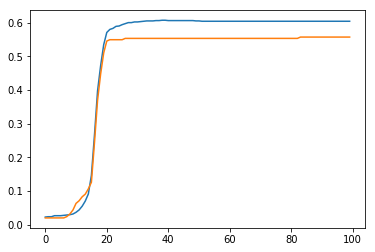

In [339]:
my_perc.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,  loss='log', 
              penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
              class_weight=None)

C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=0 loss=0.8419255081646261 tscore=0.6038306451612904 vscore=0.5568627450980392
epoch=1 loss=0.7361353556535457 tscore=0.6129032258064516 vscore=0.5764705882352941
epoch=2 loss=0.7208177788593417 tscore=0.6129032258064516 vscore=0.5843137254901961
epoch=3 loss=0.7023851069133257 tscore=0.6280241935483871 vscore=0.5882352941176471
epoch=4 loss=0.6836055711556146 tscore=0.6592741935483871 vscore=0.6549019607843137
epoch=5 loss=0.6764239466185951 tscore=0.6653225806451613 vscore=0.6549019607843137
epoch=6 loss=0.6661861132309715 tscore=0.688508064516129 vscore=0.6784313725490196
epoch=7 loss=0.6487486954066244 tscore=0.657258064516129 vscore=0.6431372549019608
epoch=8 loss=0.6383212007996504 tscore=0.6834677419354839 vscore=0.6509803921568628
epoch=9 loss=0.6249402068757307 tscore=0.7792338709677419 vscore=0.7764705882352941
epoch=10 loss=0.6173953130053738 tscore=0.8024193548387096 vscore=0.792156862745098
epoch=11 loss=0.6049828946118909 tscore=0.7893145161290323 vscore=0.7803921568

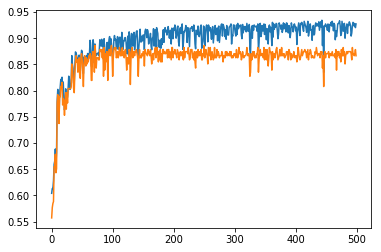

In [340]:
my_MLP.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)

C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


epoch=0 tscore=0.6038306451612904 vscore=0.5568627450980392
epoch=1 tscore=0.6038306451612904 vscore=0.5568627450980392
epoch=2 tscore=0.6179435483870968 vscore=0.5882352941176471
epoch=3 tscore=0.6169354838709677 vscore=0.5882352941176471
epoch=4 tscore=0.6169354838709677 vscore=0.5882352941176471
epoch=5 tscore=0.6169354838709677 vscore=0.5882352941176471
epoch=6 tscore=0.6169354838709677 vscore=0.5882352941176471
epoch=7 tscore=0.6169354838709677 vscore=0.5882352941176471
epoch=8 tscore=0.6169354838709677 vscore=0.5882352941176471
epoch=9 tscore=0.6169354838709677 vscore=0.5882352941176471
epoch=10 tscore=0.6169354838709677 vscore=0.5882352941176471
epoch=11 tscore=0.6169354838709677 vscore=0.5882352941176471
epoch=12 tscore=0.6169354838709677 vscore=0.5882352941176471
epoch=13 tscore=0.6169354838709677 vscore=0.5882352941176471
epoch=14 tscore=0.6169354838709677 vscore=0.5882352941176471
epoch=15 tscore=0.6169354838709677 vscore=0.5882352941176471
epoch=16 tscore=0.6169354838709677

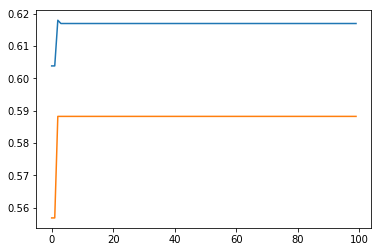

In [344]:
my_lr.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

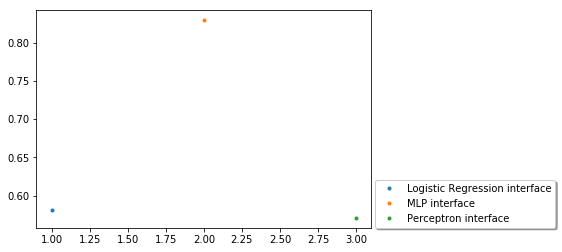

best is MLP interface with score 0.83


In [353]:
test_sup(*data.get_valid(), my_lr, my_MLP, my_perc)